[View in Colaboratory](https://colab.research.google.com/github/toanchitran/tensorflow/blob/master/notmnist.ipynb)

In [1]:
!pip install imageio
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

%matplotlib inline

In [2]:
url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified ./notMNIST_large.tar.gz
Found and verified ./notMNIST_small.tar.gz


In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

./notMNIST_large already present - Skipping extraction of ./notMNIST_large.tar.gz.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
./notMNIST_small already present - Skipping extraction of ./notMNIST_small.tar.gz.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/F', './notMNIST_small/G', './notMNIST_small/H', './notMNIST_small/I', './notMNIST_small/J']


In [4]:
Image(os.getcwd()+'/notMNIST_small/A/MDEtMDEtMDAudHRm.png')

In [0]:
#Get test and train data paths

def get_dir_paths(root):
  return [os.path.join(root, n) for n in sorted(os.listdir(root)) if os.path.isdir(os.path.join(root, n))]

def get_file_paths(root):
  return [os.path.join(root, n) for n in sorted(os.listdir(root)) if os.path.isfile(os.path.join(root, n))]


train_data_paths = get_dir_paths('./notMNIST_large')
test_data_paths = get_dir_paths('./notMNIST_small')

In [6]:
#Display train data set image samples
for i in np.arange(5):
  display(Image(filename=np.random.choice(get_file_paths(np.random.choice(train_data_paths)))))

In [7]:
#Dispplay test data set image samples

for i in np.arange(5):
  display(Image(filename=np.random.choice(get_file_paths(np.random.choice(test_data_paths)))))

In [0]:
image_size = 28
pixel_depth = 255

image_file = np.random.choice(get_file_paths(np.random.choice(train_data_paths)))
image_data = (imageio.imread(image_file).astype(float) - pixel_depth/2)/pixel_depth

In [9]:
image_data.shape

(28, 28)

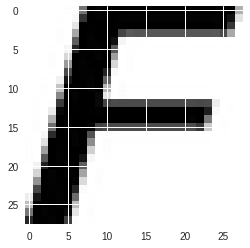

In [10]:
plt.imshow(image_data)
plt.show()

In [11]:
display(Image(filename=image_file))

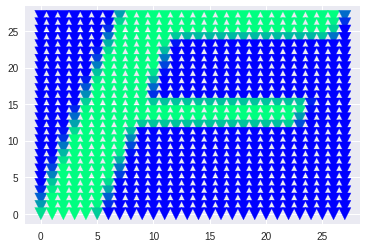

In [12]:
#Plot image using a scatterplot
colors = [str(i/pixel_depth) for i in np.ravel(image_data)]
plt.scatter(
    np.tile(np.arange(image_size), image_size),
    np.repeat(np.flipud(np.arange(image_size)), image_size),
    s=150,
    c=colors,
    marker='v',
    cmap=plt.cm.winter
)
plt.show()

In [13]:


def load_letter(folder, min_num_images):
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size), dtype=np.float32)
  
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - pixel_depth/2)/pixel_depth
      
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' %str(image_data.shape))
        dataset[num_images, :, :] = image_data
        num_images = num_images+1
        
    except (IOError, ValueError) as e:
      print('Could not read: ', image_file, ' : ', e, '- it\' s ok. Skipping')
      
      
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))
    
    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard Deviation:', np.std(dataset))
    
    return dataset
  
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder+'.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to',set_filename, ':', e)
        
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling ./notMNIST_large/A.pickle.
./notMNIST_large/A
Could not read:  ./notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png  :  Could not find a format to read the specified file in mode 'i' - it' s ok. Skipping
Could not read:  ./notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png  :  Could not find a format to read the specified file in mode 'i' - it' s ok. Skipping
Could not read:  ./notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png  :  Could not find a format to read the specified file in mode 'i' - it' s ok. Skipping


Exception: ignored

In [14]:
train_datasets

['./notMNIST_large/A.pickle',
 './notMNIST_large/B.pickle',
 './notMNIST_large/C.pickle',
 './notMNIST_large/D.pickle',
 './notMNIST_large/E.pickle',
 './notMNIST_large/F.pickle',
 './notMNIST_large/G.pickle',
 './notMNIST_large/H.pickle',
 './notMNIST_large/I.pickle',
 './notMNIST_large/J.pickle']

In [15]:

train_A = pickle.load(open(train_datasets[0], 'rb'))
train_A.shape

(52909, 28, 28)

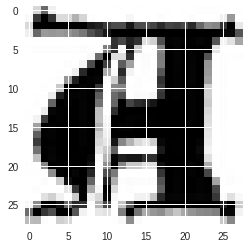

In [16]:
plt.imshow(train_A[0,:,:])

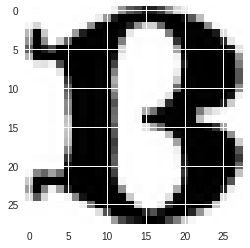

In [17]:
train_B = pickle.load(open(train_datasets[1], 'rb'))
plt.imshow(train_B[0,:,:])

In [18]:
print('Checking number of images per class')
for letter in train_datasets:
  dataset = pickle.load(open(letter, 'rb'))
  print(letter + ' size:' + str(dataset.shape[0]))
  
for letter in test_datasets:
  dataset = pickle.load(open(letter, 'rb'))
  print(letter + ' size:' + str(dataset.shape[0]))

Checking number of images per class
./notMNIST_large/A.pickle size:52909
./notMNIST_large/B.pickle size:52911
./notMNIST_large/C.pickle size:52912
./notMNIST_large/D.pickle size:52911
./notMNIST_large/E.pickle size:52912
./notMNIST_large/F.pickle size:52912
./notMNIST_large/G.pickle size:52912
./notMNIST_large/H.pickle size:52912
./notMNIST_large/I.pickle size:52912
./notMNIST_large/J.pickle size:52911
./notMNIST_small/A.pickle size:1872
./notMNIST_small/B.pickle size:1873
./notMNIST_small/C.pickle size:1873
./notMNIST_small/D.pickle size:1873
./notMNIST_small/E.pickle size:1873
./notMNIST_small/F.pickle size:1872
./notMNIST_small/G.pickle size:1872
./notMNIST_small/H.pickle size:1872
./notMNIST_small/I.pickle size:1872
./notMNIST_small/J.pickle size:1872


In [19]:
train_size = 20000
test_size = 10000
valid_size = 10000
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [0]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

In [0]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [22]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800441




To check whether two images are duplicates it suffices to check if their matrix representations are equal. The main limitation of this approach is that it only detecs exact duplicates. There are other methods for identifying near duplicates.

There are two main classes of methods for detecting near duplicates among images. One of these two method classes is known as image fingerprinting or image hashing. The main idea of image hashing is to construct a unique numerical value, known as image hash, from the contents of the image. The hash plays the role of a fingerprint in the sense that it uniquely identifies its associated image. Images that are “similar” should have “similar” hashes.

Another class of algorithms compares a pair of images by computing a metric of similarity based on the contents of both images. Various similarity metrics are used in practice, such as the mean squared error (MSE) or the structural similarity index (SSIM).

In this notebook, near-duplicates are found using image hashing.

---


###Difference hashing (dHash) algorithm



One potential approach to image hash creation is to make use of cryptographic hashing algorithms such as MD5 or SHA-1. However, if an image has been edited even slightly, the avalance effect of the cryptographic algorithm would generate a hash for the slightly edited image very different from the hash of the original image.

For this reason, alternative hashing algorithms are used for image hashing. In what follows, the difference hashing algorithm (dHash) will be presented. dHash computes the difference in brightness between adjacent pixels. It is a simple algorithm to implement. Its main steps are the following:

    Grayscale the image.
    Shrink the image.
    Compare the intensity values of adjacent pixels row-wise. Introduce a binary classification scheme to compare adjacent pixels; if the intensity value of the preceding pixel is higher than the intensity value of the succeeding pixel in the row, then label the difference between the two adjacent pixels as 1, otherwise as 0.
    Convert the resulting binary vector of ones and zeros to a hexadecimal string, which is the image hash.



In [0]:
#Function for computing the difference of an image
import PIL

def image_dhash(image, hsize=8):
  
  icon = PIL.Image.fromarray(image).convert('L').resize((hsize+1, hsize), PIL.Image.ANTIALIAS)
  icon = np.array(icon)
  
  diff = np.empty([hsize, hsize], dtype=np.bool_)
  for row in np.arange(hsize):
    for col in np.arange(hsize):
      diff[row, col] = icon[row, col] > icon[row, col+1]
      
  hexadecimal = np.empty(hsize, dtype=np.dtype('U', int(hsize/4)))
  for i in np.arange(hsize):
    hexadecimal[i] = hex(int(''.join(str(b) for b in np.flipud(diff[i,:].astype(int))), 2))[2:].rjust(2, '0')
    
  return ''.join(hexadecimal)

In [0]:
hash_size = 8

#Compute difference hashes of image in the train dataset
train_dhashes = np.empty(train_size, dtype=np.dtype('U', int((hash_size**2)/4)))
for i in np.arange(train_size):
  train_dhashes[i] = image_dhash(train_dataset[i,:,:])
  
#Compute difference hashes of image in the test dataset
test_dhashes = np.empty(test_size, dtype=np.dtype('U', int((hash_size**2)/4)))
for i in np.arange(test_size):
  test_dhashes[i] = image_dhash(test_dataset[i,:,:])
  
#Compute difference hashes of image in the validation dataset
valid_dhashes = np.empty(valid_size, dtype=np.dtype('U', int((hash_size**2)/4)))
for i in np.arange(valid_size):
  valid_dhashes[i] = image_dhash(valid_dataset[i,:,:])

In [38]:


## Get locations of images in the train dataset after excluding near-duplicates

unique_train_dhashes, unique_train_locations = np.unique(train_dhashes, return_index=True)

print('Number of images in train dataset: %d' % train_size)
print('Number of images in train dataset after excluding near-duplicates: %d' % np.size(unique_train_locations))
print('%.2f%% of images in train dataset kept' % round(100*np.float32(np.size(unique_train_locations))/train_size, 2))



Number of images in train dataset: 200000
Number of images in train dataset after excluding near-duplicates: 1
0.00% of images in train dataset kept


In [32]:
train_sample_1000 = train_dataset[:1000,:,:]
train_sample_labels_1000 = train_labels[:1000]

(samples, width, height) = train_sample_1000.shape
train_sample_1000 = np.reshape(train_sample_1000, (samples, width * height))

(samples, width, height) = test_dataset.shape
test_dataset_reshaped = np.reshape(test_dataset, (samples, width * height))
logreg = LogisticRegression(C=1, multi_class='multinomial', solver='lbfgs', penalty='l2')
logreg.fit(train_sample_1000, train_sample_labels_1000)
logreg_train_score_1000 = logreg.score(train_sample_1000, train_sample_labels_1000)
logreg_test_score_1000 = logreg.score(test_dataset_reshaped, test_labels)
print('Training score = ', logreg_train_score_1000)
print('Test score = ', logreg_test_score_1000)

Training score =  0.998
Test score =  0.8426
